In [1]:
#import libraries
from pyspark.sql.functions import avg, stddev, split, udf, isnull, first, col, format_number, rand
from pyspark.sql import Window
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import sum
import pyspark.sql.functions as F 
from pyspark.ml.feature import RegexTokenizer, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression, GBTClassifier,LinearSVC, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20200922021227-0000
KERNEL_ID = efd557bb-1a38-487d-a696-ee08c94bad79


In [2]:
# The code was removed by Watson Studio for sharing.

# Load the Data

In [3]:
df_data_1 = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-svc69m2bztpos8'))
df_data_1.take(5)


[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

# Explore the data structure

In [4]:
df_data_1.show(1)

+-------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------+-------------+---------+-------------+------+-------------+--------------------+------+
|       artist|     auth|firstName|gender|itemInSession|lastName|   length|level|          location|method|    page| registration|sessionId|         song|status|           ts|           userAgent|userId|
+-------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------+-------------+---------+-------------+------+-------------+--------------------+------+
|Martin Orford|Logged In|   Joseph|     M|           20| Morales|597.55057| free|Corpus Christi, TX|   PUT|NextSong|1532063507000|      292|Grand Designs|   200|1538352011000|"Mozilla/5.0 (Mac...|   293|
+-------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------+-------------+---------+-------------+------+-------------+---------

In [5]:
df_data_1.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
df_data_1.describe('userId').show()

+-------+------------------+
|summary|            userId|
+-------+------------------+
|  count|            543705|
|   mean| 60268.42669103512|
| stddev|109898.82324176628|
|    min|                  |
|    max|                99|
+-------+------------------+



In [7]:
df_data_1.describe("artist").show()

+-------+-----------------+
|summary|           artist|
+-------+-----------------+
|  count|           432877|
|   mean|527.5289537712895|
| stddev|966.1072451772758|
|    min|              !!!|
|    max|ÃÂlafur Arnalds|
+-------+-----------------+



## Drop Rows with Missing Values

In [8]:
df_data_1.count()

543705

In [9]:
#Drop NaNs
user_log_valid = df_data_1.dropna(how = "any", subset = ["userId", "sessionId"])

In [10]:
user_log_valid.count()

543705

In [11]:
#drop empty user ids
user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")

In [12]:
user_log_valid.count()

528005

## Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [13]:
# label downgrades
find_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
user_log_valid = user_log_valid.withColumn("downgrade_event", find_downgrade_event("page"))

# label users that have downgraded their accounts
window = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
user_log_valid = user_log_valid.withColumn('downgrade_event', sum("downgrade_event").over(window))

# label churn events
find_churn_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
user_log_valid = user_log_valid.withColumn('churn_event', find_churn_event('page'))

# find users that have churned
user_log_valid = user_log_valid.withColumn("churn_event", sum("churn_event").over(window))

In [14]:
user_log_valid.head()

Row(artist='Darude', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=226.08934, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=62, song='Sandstorm', status=200, ts=1538991392000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', downgrade_event=0, churn_event=1)

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [15]:
user_log_valid_pd = user_log_valid.toPandas()
user_log_valid_pd.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,downgrade_event,churn_event
0,Darude,Logged In,Darianna,F,0,Carpenter,226.08934,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,62,Sandstorm,200,1538991392000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,1
1,Justice,Logged In,Darianna,F,1,Carpenter,285.41342,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,62,Phantom Part 1.5 (Album Version),200,1538991618000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,1
2,Five Iron Frenzy,Logged In,Darianna,F,2,Carpenter,236.09424,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,62,Canada,200,1538991903000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,1
3,Carpenters,Logged In,Darianna,F,3,Carpenter,250.25261,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,62,Ticket To Ride,200,1538992139000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,1
4,Uffie,Logged In,Darianna,F,4,Carpenter,227.52608,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,62,Dismissed (Uffie),200,1538992389000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,1


In [16]:
user_log_valid_pd['churn_event'].describe()

count    528005.000000
mean          0.196297
std           0.397196
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: churn_event, dtype: float64

In [17]:
user_log_valid_pd['userId'].nunique()

448

In [18]:
user_log_valid_pd['sessionId'].nunique()

4470

In [19]:
user_log_valid_pd['churn_event'].sum()

103646

In [20]:
len(user_log_valid_pd)

528005

In [21]:
user_log_valid_pd.groupby('userId')['churn_event'].sum()

userId
10         423
100          0
100001     134
100002       0
100003     827
100004     373
100005     100
100006       0
100007       0
100008       0
100009       0
100010     137
100011    1303
100012     167
100013      27
100014     406
100015       0
100016     200
100017     178
100018     169
100019       0
100020       0
100021       0
100022       0
100023     174
100024    1084
100025     903
100026       0
100027       0
100028     707
          ... 
71           0
72           0
73           0
74           0
75           0
76           0
77           0
78           0
79           0
8            0
80           0
81        1974
82           0
83           0
85        2696
86           0
87           0
88        2359
89         396
9            0
90           0
91           0
92           0
93           0
94           0
95           0
96           0
97           0
98           0
99           0
Name: churn_event, Length: 448, dtype: int64

In [22]:
sampledf = user_log_valid_pd[user_log_valid_pd['userId']== '100013']
sampledf

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,downgrade_event,churn_event
427561,Mariah Carey,Logged In,Cali,F,0,Brown,234.00444,free,"Cleveland-Elyria, OH",PUT,NextSong,1537367773000,13,Dreamlover,200,1538503066000,"""Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537....",100013,0,1
427562,Jill Scott,Logged In,Cali,F,1,Brown,209.68444,free,"Cleveland-Elyria, OH",PUT,NextSong,1537367773000,13,Hate On Me,200,1538503300000,"""Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537....",100013,0,1
427563,The Rolling Stones,Logged In,Cali,F,2,Brown,271.49016,free,"Cleveland-Elyria, OH",PUT,NextSong,1537367773000,13,Angie (1993 Digital Remaster),200,1538503509000,"""Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537....",100013,0,1
427564,None,Logged In,Cali,F,3,Brown,NaN,free,"Cleveland-Elyria, OH",PUT,Thumbs Up,1537367773000,13,None,307,1538503510000,"""Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537....",100013,0,1
427565,The Lettermen,Logged In,Cali,F,4,Brown,157.83138,free,"Cleveland-Elyria, OH",PUT,NextSong,1537367773000,13,Put Your Head On My Shoulder (1987 Digital Rem...,200,1538503780000,"""Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537....",100013,0,1
427566,None,Logged In,Cali,F,5,Brown,NaN,free,"Cleveland-Elyria, OH",GET,Roll Advert,1537367773000,13,None,200,1538503801000,"""Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537....",100013,0,1
427567,Sylk 130,Logged In,Cali,F,6,Brown,309.44608,free,"Cleveland-Elyria, OH",PUT,NextSong,1537367773000,13,City (5-6 Theme),200,1538503937000,"""Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537....",100013,0,1
427568,None,Logged In,Cali,F,7,Brown,NaN,free,"Cleveland-Elyria, OH",PUT,Thumbs Up,1537367773000,13,None,307,1538503938000,"""Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537....",100013,0,1
427569,Florence + The Machine,Logged In,Cali,F,8,Brown,290.48118,free,"Cleveland-Elyria, OH",PUT,NextSong,1537367773000,13,Rabbit Heart (Raise It Up),200,1538504246000,"""Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537....",100013,0,1
427570,Lily Allen,Logged In,Cali,F,9,Brown,189.98812,free,"Cleveland-Elyria, OH",PUT,NextSong,1537367773000,13,LDN,200,1538504536000,"""Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537....",100013,0,1


In [23]:
# so every song listened to is listed as a churn event if the user churned. So if a user has a 1 they are a churner. Need to figure out characteristics of users that churn.
#pandas
user_log_valid_pd.drop_duplicates(subset='userId').groupby(['churn_event'])['userId'].count()

churn_event
0    349
1     99
Name: userId, dtype: int64

In [24]:
#spark
user_log_valid.dropDuplicates(['userId']).groupby(['churn_event']).count().show()

+-----------+-----+
|churn_event|count|
+-----------+-----+
|          0|  349|
|          1|   99|
+-----------+-----+



In [25]:
user_log_valid.dropDuplicates(['userId', 'gender']).groupby(['churn_event', 'gender']).count().show()

+-----------+------+-----+
|churn_event|gender|count|
+-----------+------+-----+
|          0|     F|  153|
|          1|     M|   54|
|          1|     F|   45|
|          0|     M|  196|
+-----------+------+-----+



In [26]:
user_log_valid.dropDuplicates(['userId', 'level']).groupby(['churn_event', 'level']).count().show()

+-----------+-----+-----+
|churn_event|level|count|
+-----------+-----+-----+
|          1| paid|   75|
|          1| free|   82|
|          0| free|  288|
|          0| paid|  246|
+-----------+-----+-----+



In [27]:
gender_churn_pd = user_log_valid.dropDuplicates(["userId", "gender"]).groupby(["churn_event", "gender"]).count().sort("churn_event").toPandas()

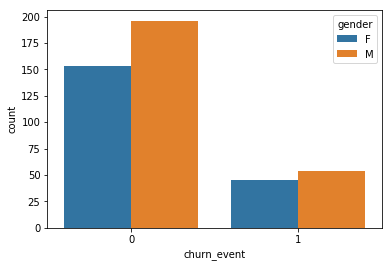

In [28]:
sns.barplot(x='churn_event', y='count', hue='gender', data=gender_churn_pd) # male customers churn a little bit more

In [29]:
level_churn_pd = user_log_valid.dropDuplicates(["userId", "level"]).groupby(["churn_event", "level"]).count().sort("churn_event").toPandas()

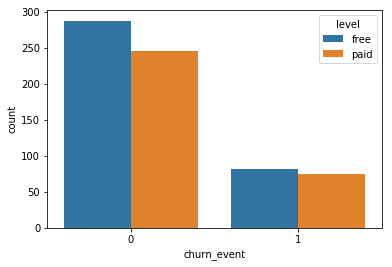

In [30]:
sns.barplot(x='churn_event', y='count', hue='level', data=level_churn_pd) 

In [31]:
free_count = len(user_log_valid_pd[user_log_valid_pd['level']=='free'])
paid_count = len(user_log_valid_pd[user_log_valid_pd['level']=='paid'])
free_percent_churn = len(user_log_valid_pd[(user_log_valid_pd['churn_event']==1)&(user_log_valid_pd['level']=='free')])/free_count
paid_percent_churn = len(user_log_valid_pd[(user_log_valid_pd['churn_event']==1)&(user_log_valid_pd['level']=='paid')])/paid_count
print('free percent churn:', free_percent_churn, 'paid percent churn:', paid_percent_churn)

free percent churn: 0.2500341030001546 paid percent churn: 0.182162643166748


Text(0, 0.5, 'Mean songs per session')

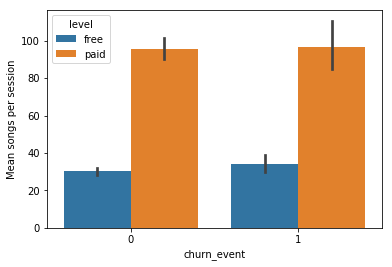

In [39]:
songs_by_level = user_log_valid.where('page == "NextSong"').groupby(['churn_event', 'userId', 'sessionId', 'level']).count().groupby(['churn_event', 'userId','level']).agg({'count':'avg'}).withColumnRenamed('avg(count)', 'avg_songs_played').toPandas()

ax = sns.barplot('churn_event', y='avg_songs_played', hue='level', data=songs_by_level)
plt.ylabel('Mean songs per session')


Text(0, 0.5, 'Mean songs per session')

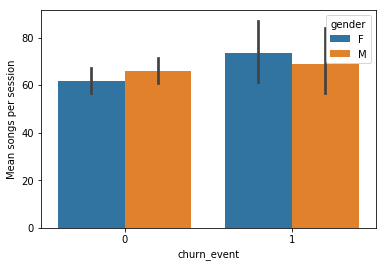

In [40]:
songs_by_gender = user_log_valid.where('page == "NextSong"').groupby(['churn_event', 'userId', 'sessionId', 'gender']).count().groupby(['churn_event', 'userId','gender']).agg({'count':'avg'}).withColumnRenamed('avg(count)', 'avg_songs_played').toPandas()

ax = sns.barplot('churn_event', y='avg_songs_played', hue='gender', data=songs_by_gender)
plt.ylabel('Mean songs per session')

In [41]:
#Need to deal with the time stamps
# udf to get hour, day, month, and day of week of cancellation

hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).month)

# Source https://stackoverflow.com/questions/38928919/how-to-get-the-weekday-from-day-of-month-using-pyspark
day_of_week = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%w'))

In [42]:
user_log_valid = user_log_valid.withColumn('hour', hour(user_log_valid.ts))
user_log_valid = user_log_valid.withColumn('day', day(user_log_valid.ts))
user_log_valid = user_log_valid.withColumn('month', month(user_log_valid.ts))
user_log_valid = user_log_valid.withColumn('day_of_week', day_of_week(user_log_valid.ts))


In [43]:
user_log_valid.collect() #make sure the udfs did their job

[Row(artist='Darude', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=226.08934, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=62, song='Sandstorm', status=200, ts=1538991392000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', downgrade_event=0, churn_event=1, hour='9', day='8', month='10', day_of_week='1'),
 Row(artist='Justice', auth='Logged In', firstName='Darianna', gender='F', itemInSession=1, lastName='Carpenter', length=285.41342, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=62, song='Phantom Part 1.5 (Album Version)', status=200, ts=1538991618000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like G

In [44]:
#function to compute what percent of users churned in a given unit time NEED TO ADD A DOCSTRING
def calc_perc_churners(df,col): 
    result_df = pd.DataFrame()
    for i in df[col].unique():
        cur_df = df[df[col]==i]
        cur_df['churn_percent'] = cur_df['count']/cur_df['count'].sum()*100
        result_df = result_df.append(cur_df)
    return result_df

In [45]:
#function to compute percent of all churners in dataset that churned during a given time period
def calc_all_churn_percent(df,col):
    churn_df = pd.DataFrame()
    for i in df[col].unique():
        cur_df =df[(df['churn_event']==1)]
        user_count = cur_df['count'].sum()
        cur_df = cur_df[cur_df[col]==i]
        cur_df['percent_churners'] = cur_df['count']/user_count*100
        churn_df = churn_df.append(cur_df)
    return churn_df

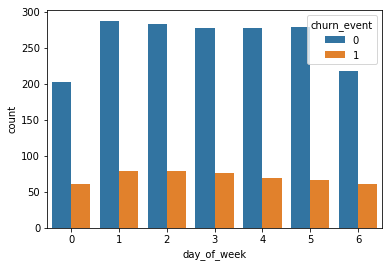

In [46]:
#churn by day of week
day_churn_pd = user_log_valid.dropDuplicates(["userId", "day_of_week"]).groupby(["day_of_week","churn_event"]).count().sort("day_of_week").toPandas()
sns.barplot(x='day_of_week', y='count', hue='churn_event', data=day_churn_pd) 

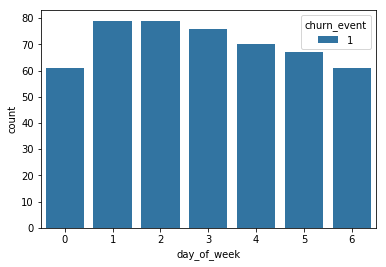

In [47]:
#focus on churners
sns.barplot(x='day_of_week', y='count', hue='churn_event', data=day_churn_pd[day_churn_pd['churn_event']==1]) 

In [48]:
import pandas as pd

/opt/ibm/conda/miniconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


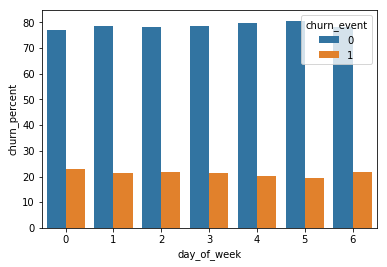

In [49]:
day_week_percents = calc_perc_churners(day_churn_pd, 'day_of_week')
sns.barplot(x='day_of_week', y='churn_percent', hue='churn_event', data=day_week_percents)

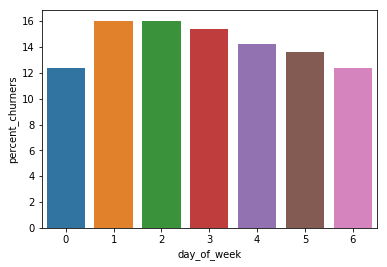

In [50]:
weekday_churn_df = calc_all_churn_percent(day_churn_pd,col='day_of_week')
sns.barplot(x='day_of_week', y = 'percent_churners', data = weekday_churn_df)

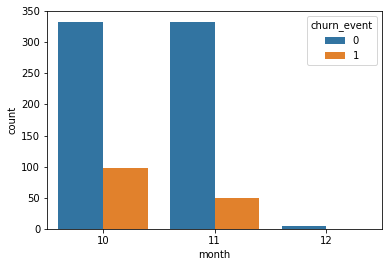

In [51]:
#churn by month
month_churn_pd = user_log_valid.dropDuplicates(["userId", "month"]).groupby(["month","churn_event"]).count().sort("month").toPandas()
sns.barplot(x='month', y='count', hue='churn_event', data=month_churn_pd) 

In [52]:
#month does not seem useful here since we have limited data. Maybe if it is represented as a percent.
#monthchurnpercent = month_churn_pd[month_churn_pd['churn_event']==1]['count']/month_churn_pd[month_churn_pd['churn_event']==1]['count'].sum()
month_churn_pd.head()

,month,churn_event,count
0,10,0,333
1,10,1,97
2,11,0,333
3,11,1,50
4,12,0,4


In [53]:
october = month_churn_pd[month_churn_pd['month']=='10']
october['churn_percent'] = october['count']/october['count'].sum()
october

/opt/ibm/conda/miniconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,month,churn_event,count,churn_percent
0,10,0,333,0.774419
1,10,1,97,0.225581


In [54]:
month_percents = calc_perc_churners(month_churn_pd, 'month')
month_percents

/opt/ibm/conda/miniconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,month,churn_event,count,churn_percent
0,10,0,333,77.44186
1,10,1,97,22.55814
2,11,0,333,86.94517
3,11,1,50,13.05483
4,12,0,4,100.00000


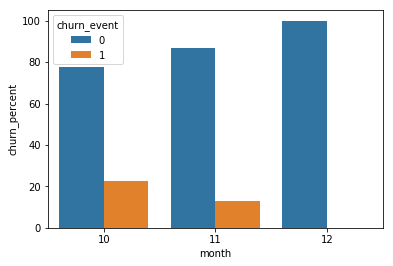

In [55]:
sns.barplot(x='month', y='churn_percent', hue='churn_event', data=month_percents) 

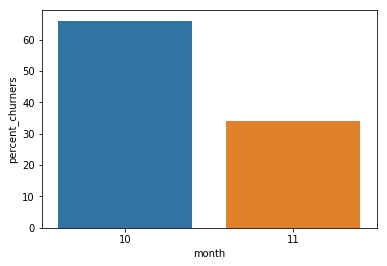

In [56]:
month_churn_df = calc_all_churn_percent(month_churn_pd,col='month')
sns.barplot(x='month', y = 'percent_churners', data = month_churn_df)

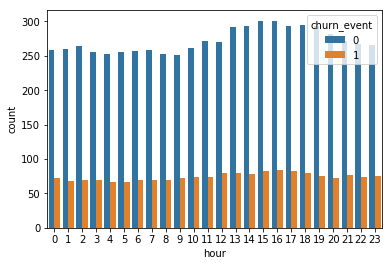

In [57]:
#churn by hour of day
hour_churn_pd = user_log_valid.dropDuplicates(["userId", "hour"]).groupby(["hour","churn_event"]).count().sort("hour").toPandas()

hour_churn_pd['hour']=hour_churn_pd['hour'].astype(int)
hour_churn_pd.sort_values(by='hour')
sns.barplot(x='hour', y='count', hue='churn_event', data=hour_churn_pd) 

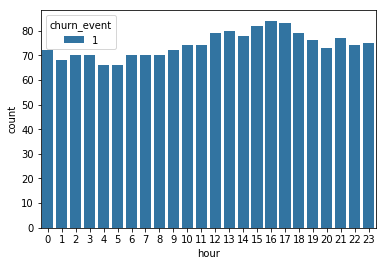

In [58]:
#focus on churners
sns.barplot(x='hour', y='count', hue='churn_event', data=hour_churn_pd[hour_churn_pd['churn_event']==1]) 

/opt/ibm/conda/miniconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


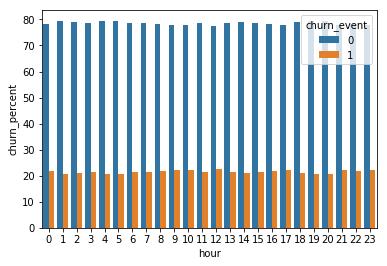

In [59]:
hour_percents = calc_perc_churners(hour_churn_pd, 'hour')
sns.barplot(x='hour', y = 'churn_percent', hue='churn_event', data = hour_percents)

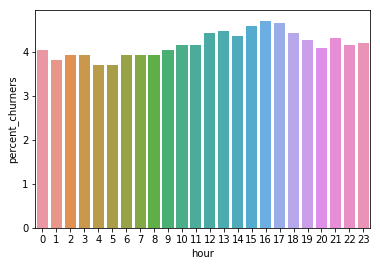

In [60]:
hour_churn_df = calc_all_churn_percent(hour_churn_pd,col='hour')
sns.barplot(x='hour', y = 'percent_churners', data = hour_churn_df)

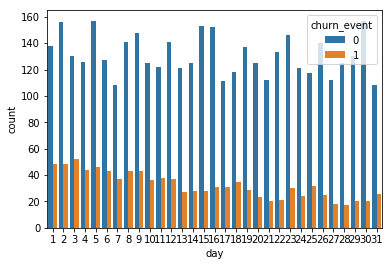

In [61]:
#churn by day of month
daynum_churn_pd = user_log_valid.dropDuplicates(["userId", "day"]).groupby(["day","churn_event"]).count().sort("day").toPandas()

daynum_churn_pd['day']=daynum_churn_pd['day'].astype(int)
daynum_churn_pd.sort_values(by='day')
sns.barplot(x='day', y='count', hue='churn_event', data=daynum_churn_pd) 

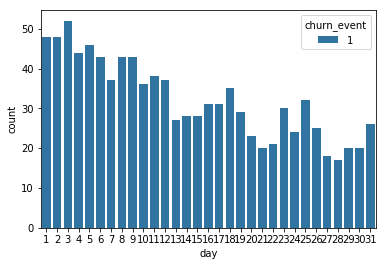

In [62]:
#focus on churners
sns.barplot(x='day', y='count', hue='churn_event', data=daynum_churn_pd[daynum_churn_pd['churn_event']==1]) 

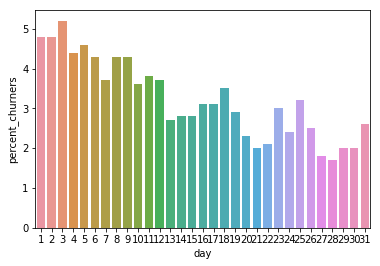

In [63]:
daynum_churn_df = calc_all_churn_percent(daynum_churn_pd,col='day')
sns.barplot(x='day', y = 'percent_churners', data = daynum_churn_df)

### What about location?

In [64]:
get_location = udf(lambda x: x.split(',')[1].strip())
user_log_valid = user_log_valid.withColumn("location", get_location(user_log_valid.location))

In [65]:
user_log_valid.take(1)

[Row(artist='Darude', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=226.08934, level='free', location='CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=62, song='Sandstorm', status=200, ts=1538991392000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', downgrade_event=0, churn_event=1, hour='9', day='8', month='10', day_of_week='1')]

In [66]:
#churn by location
#churn by day of month
loc_churn_pd = user_log_valid.dropDuplicates(["userId", "location"]).groupby(["location","churn_event"]).count().sort("location").toPandas()

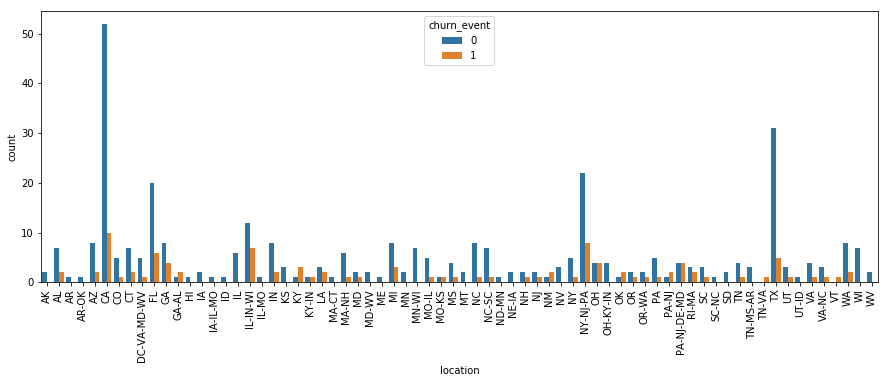

In [67]:
plt.figure(figsize=(15,5))
plot1=sns.barplot(x='location', y ='count', hue = 'churn_event', data = loc_churn_pd)
plot1.set_xticklabels(plot1.get_xticklabels(),rotation=90);

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### Features of Interest
Categorical:
1. gender: 'gender'
2. region: use get_region udf
3. Paid vs. Free: 'level'

Numeric:
1. Day of Week: use day udf
2. Hour of the Day: use hour udf
3. Day of Month: use month udf
4. Number of thumbs up: user_log_valid.page == 'Thumbs Up'
5. Number of thumbs down: user_log_valid.page == 'Thumbs Down'
6. Number of friends invited: user_log_valid.page == 'Add Friend'
7. Total listening time: use 'length' to calculate
8. Number of sessions: use sessionId to calculate
9. Length of subscription: use 'registration' time and calculate
10. Number of songs listened to: use 'song' to calculate

Target:
churn

In [5]:
df = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-svc69m2bztpos8'))

In [6]:
df.take(1)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293')]

In [7]:
# list of udfs
window = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
find_churn_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
get_region = udf(lambda x: x.split(',')[1].strip())
hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).month)

# Source https://stackoverflow.com/questions/38928919/how-to-get-the-weekday-from-day-of-month-using-pyspark
day_of_week = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%w'))



In [8]:
def feature_engineering(df):
    eng_df=df.filter(df["userId"] != "")
   
    #define churn
    eng_df = eng_df.withColumn("churn_event", find_churn_event("page"))
    eng_df = eng_df.withColumn("churn_event", sum("churn_event").over(window))
    #gender
    gender = eng_df.select("userId", "gender").dropDuplicates().replace(['M', 'F'], ['0', '1'], 'gender').select('userId', col('gender').cast('int'))
    #level
    level = eng_df.select("userId", "level").dropDuplicates().replace(['free', 'paid'], ['0','1'], 'level').select('userId', col('level').cast('int'))
    #day/time stuff
    eng_df = eng_df.withColumn('hour', hour(eng_df.ts))
    hourdf = eng_df.select("userId", "hour").dropDuplicates().select('userId', col('hour').cast('int'))
    eng_df = eng_df.withColumn('day', day(eng_df.ts))
    daydf = eng_df.select("userId", "day").dropDuplicates().select('userId', col('day').cast('int'))
    eng_df = eng_df.withColumn('month', month(eng_df.ts))
    monthdf = eng_df.select("userId", "month").dropDuplicates().select('userId', col('month').cast('int'))
    eng_df = eng_df.withColumn('day_of_week', day_of_week(eng_df.ts))
    weekdaydf = eng_df.select("userId", "day_of_week").dropDuplicates().select('userId', col('day_of_week').cast('int'))
    #thumbs up / thumbs down
    thumbup = eng_df.select('userId','page').where(eng_df.page == 'Thumbs Up').groupBy('userID').count().withColumnRenamed('count', 'number_thumbs_up') 
    thumbdown = eng_df.select('userId','page').where(eng_df.page == 'Thumbs Down').groupBy('userID').count().withColumnRenamed('count', 'number_thumbs_down') 
    #add friend
    addfriend = eng_df.select('userId','page').where(eng_df.page == 'Add Friend').groupBy('userID').count().withColumnRenamed('count', 'add_friend') 
    #listen time
    listentime = eng_df.select('userId', 'length').groupby('userId').sum().withColumnRenamed('sum(length)', 'listentime')
    #total songs
    songs = eng_df.select('userId','song').groupBy('userId').count().withColumnRenamed('count', 'song_count')
    #time since registration
    timereg = eng_df.select('userId','registration','ts').withColumn('lifetime',(eng_df.ts-eng_df.registration)).groupBy('userId').agg({'lifetime':'max'}).withColumnRenamed('max(lifetime)','lifetime') \
    .select('userId', (col('lifetime')/1000/3600/24).alias('lifetime'))
    #churn label
    churn = eng_df.select('userId', col('churn_event').alias('churn')).dropDuplicates()
    #combine all the data
    data = gender.join(level, 'userId', 'outer').join(churn, 'userId', 'outer').join(hourdf, 'userId', 'outer'). \
    join(daydf, 'userId', 'outer').join(monthdf, 'userId', 'outer').join(weekdaydf, 'userId', 'outer').join(thumbup, 'userId', 'outer').join(thumbdown, 'userId', 'outer'). \
    join(addfriend, 'userId', 'outer').join(listentime, 'userId', 'outer').join(songs, 'userId', 'outer').join(timereg, 'userId', 'outer').fillna(0)
    return data

In [71]:
del(user_log_valid)
del(user_log_valid_pd)
del(df_data_1)

In [9]:
data = feature_engineering(df)

In [73]:
data.take(1)

[Row(gender=1, level=0, churn=1, hour=12, day=8, month=10, day_of_week=1, number_thumbs_up=4, number_thumbs_down=3, add_friend=3, listentime=25870.950739999997, song_count=137, lifetime=14.328449074074074)]

In [79]:
#save the data
data.write.save('finaldata2.CSV', format='csv', header=True)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [80]:
data.columns

['userId',
 'gender',
 'level',
 'churn',
 'hour',
 'day',
 'month',
 'day_of_week',
 'number_thumbs_up',
 'number_thumbs_down',
 'add_friend',
 'listentime',
 'song_count',
 'lifetime']

In [10]:
feature_labels = data.columns[1:3]+data.columns[4:] #don't want userId or churn

In [11]:
feature_labels

['gender',
 'level',
 'hour',
 'day',
 'month',
 'day_of_week',
 'number_thumbs_up',
 'number_thumbs_down',
 'add_friend',
 'listentime',
 'song_count',
 'lifetime']

In [12]:
features_vector = VectorAssembler(inputCols=data.columns[1:3]+data.columns[4:], outputCol='features')

In [13]:
inputs = features_vector.transform(data)

In [14]:
inputs.show(1)

+------+------+-----+-----+----+---+-----+-----------+----------------+------------------+----------+------------------+----------+------------------+--------------------+
|userId|gender|level|churn|hour|day|month|day_of_week|number_thumbs_up|number_thumbs_down|add_friend|        listentime|song_count|          lifetime|            features|
+------+------+-----+-----+----+---+-----+-----------+----------------+------------------+----------+------------------+----------+------------------+--------------------+
|100010|     1|    0|    1|  12|  8|   10|          1|               4|                 3|         3|25870.950739999997|       137|14.328449074074074|[1.0,0.0,12.0,8.0...|
+------+------+-----+-----+----+---+-----+-----------+----------------+------------------+----------+------------------+----------+------------------+--------------------+
only showing top 1 row



In [15]:
features_scaler = StandardScaler(withMean=True, withStd=True, inputCol='features', outputCol='scaled_features')
features_scaler_fit = features_scaler.fit(inputs)
inputs_scaled = features_scaler_fit.transform(inputs)

In [16]:
ml_data = inputs_scaled.select(inputs_scaled.churn.alias('label'), inputs_scaled.scaled_features.alias('features'))

### Train, test, split

In [17]:
train, rest = ml_data.randomSplit([0.6,0.4], seed=42)
validation, test = rest.randomSplit([0.5,0.5], seed=42)

### Logistic Regression

In [42]:
# classifier
lr = LogisticRegression(maxIter=10)

# evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

#paramGrid
paramGrid = ParamGridBuilder().build()

crossval_lr = CrossValidator(estimator=lr, evaluator=f1_evaluator, estimatorParamMaps=paramGrid, numFolds=3)

In [43]:
lr_model = crossval_lr.fit(train)


In [44]:
lr_model.avgMetrics

[0.7683126630090035]

In [45]:
lr_results = lr_model.transform(validation)

In [46]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Logistic Regression Evaluation:')
print('Accuracy: {}'.format(evaluator.evaluate(lr_results, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(lr_results, {evaluator.metricName: "f1"})))

Logistic Regression Evaluation:
Accuracy: 0.8203335464945136
F-1 Score:0.7679907431478293


In [47]:
your_lr_model = lr_model.bestModel

### Random Forest Model

In [49]:
#classifier
rf = RandomForestClassifier()

#evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

#paramGrid
paramGrid = ParamGridBuilder().build()

crossval_rf = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=f1_evaluator, numFolds=3)

In [50]:
rf_model = crossval_rf.fit(train)
rf_model.avgMetrics


[0.883981138374397]

In [51]:
rf_results = rf_model.transform(validation)

In [52]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Random Forest Evaluation:')
print('Accuracy: {}'.format(evaluator.evaluate(rf_results, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(rf_results, {evaluator.metricName: "f1"})))

Random Forest Evaluation:
Accuracy: 0.906927738359877
F-1 Score:0.8943337312654192


### Gradient Boost

In [18]:
gb = GBTClassifier(maxIter=10,seed=42)
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')
paramGrid = ParamGridBuilder().build()
crossval_gb = CrossValidator(estimator=gb, estimatorParamMaps=paramGrid, evaluator=f1_evaluator, numFolds=3)

In [19]:
gb_model = crossval_gb.fit(train)
gb_model.avgMetrics

[0.9391951554502226]

In [20]:
gb_results = gb_model.transform(validation)

In [21]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Gradient Boost Evaluation:')
print('Accuracy: {}'.format(evaluator.evaluate(gb_results, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(gb_results, {evaluator.metricName: "f1"})))

Gradient Boost Evaluation:
Accuracy: 0.942586558665002
F-1 Score:0.938633239174006


In [40]:
your_model_gb = gb_model.bestModel 
print(feature_labels)
print(your_model_gb.featureImportances)

['gender', 'level', 'hour', 'day', 'month', 'day_of_week', 'number_thumbs_up', 'number_thumbs_down', 'add_friend', 'listentime', 'song_count', 'lifetime']
(12,[0,1,2,3,4,5,6,7,8,9,10,11],[0.02045793712492947,0.0008165491533482468,3.1617977327452796e-17,0.000544891502881783,0.006818562761166108,5.373566039380211e-17,0.10406454669880746,0.18502687732921566,0.19770475183821448,0.12630502172085184,0.07901670256474201,0.27924415930584295])


Text(0, 0.5, 'Feature')

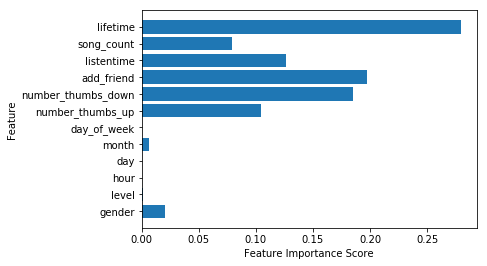

In [39]:
featimport = your_model_gb.featureImportances.values
y_length = np.arange(len(feature_labels))
plt.barh(y_length, featimport)
plt.yticks(y_length, feature_labels)
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')

### Decision Tree

In [23]:
dt = DecisionTreeClassifier()
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')
paramGrid = ParamGridBuilder().build()
crossval_dt = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=f1_evaluator, numFolds=3)

In [24]:
dt_model = crossval_dt.fit(train)
dt_model.avgMetrics

[0.8923718901339199]

In [25]:
dt_results = dt_model.transform(validation)

In [26]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Decision Tree Evaluation:')
print('Accuracy: {}'.format(evaluator.evaluate(dt_results, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(dt_results, {evaluator.metricName: "f1"})))

Gradient Boost Evaluation:
Accuracy: 0.9013266745840819
F-1 Score:0.8890563460568852


### Test Parameters for the Best Model

In [59]:
gb2 = GBTClassifier(seed=42)
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')
paramGrid_gbmodel = ParamGridBuilder().addGrid(gb2.maxDepth,[5, 10]).addGrid(gb2.maxIter, [5,10]).build()
crossval_gb2 = CrossValidator(estimator=gb, estimatorParamMaps=paramGrid, evaluator=f1_evaluator, numFolds=3)


In [60]:
gb_model2 = crossval_gb2.fit(train)
gb_model2.avgMetrics

[0.9391951554502226]

In [61]:
gb2_results = gb_model2.transform(validation)

In [62]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Gradient Boost Evaluation:')
print('Accuracy: {}'.format(evaluator.evaluate(gb2_results, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(gb2_results, {evaluator.metricName: "f1"})))

Gradient Boost Evaluation:
Accuracy: 0.942586558665002
F-1 Score:0.938633239174006


In [92]:
gb_model2.bestModel

GBTClassificationModel (uid=GBTClassifier_43aeb20dc33a) with 10 trees

In [93]:
your_model_gb2 = gb_model2.bestModel 
print(feature_labels)
print(your_model_gb2.featureImportances)

['gender', 'level', 'hour', 'day', 'month', 'day_of_week', 'number_thumbs_up', 'number_thumbs_down', 'add_friend', 'listentime', 'song_count', 'lifetime']
(12,[0,1,2,3,4,5,6,7,8,9,10,11],[0.02045793712492947,0.0008165491533482468,3.1617977327452796e-17,0.000544891502881783,0.006818562761166108,5.373566039380211e-17,0.10406454669880746,0.18502687732921566,0.19770475183821448,0.12630502172085184,0.07901670256474201,0.27924415930584295])


Text(0, 0.5, 'Feature')

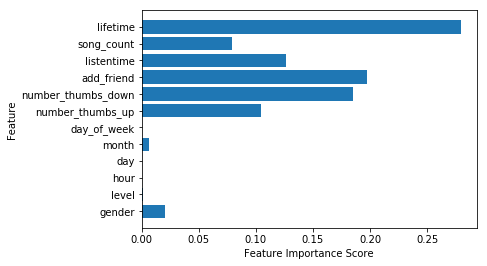

In [94]:
featimport = your_model_gb2.featureImportances.values
y_length = np.arange(len(feature_labels))
plt.barh(y_length, featimport)
plt.yticks(y_length, feature_labels)
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')

In [69]:
# make a plot for most important feature
datapd = data.toPandas()

Text(0, 0.5, 'Count')

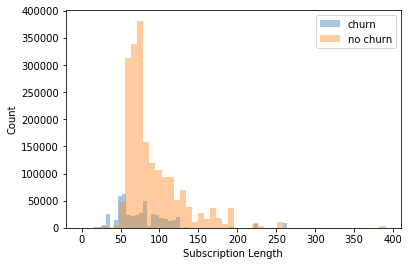

In [80]:
sns.distplot(datapd[datapd['churn']==1]['lifetime'], kde=False, label = 'churn')
sns.distplot(datapd[datapd['churn']==0]['lifetime'], kde=False, label = 'no churn')
plt.legend()
plt.xlabel('Subscription Length')
plt.ylabel('Count')

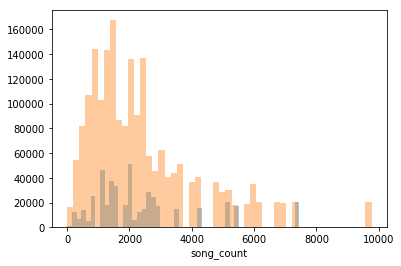

In [77]:
sns.distplot(datapd[datapd['churn']==1]['song_count'], kde=False)
sns.distplot(datapd[datapd['churn']==0]['song_count'], kde=False)

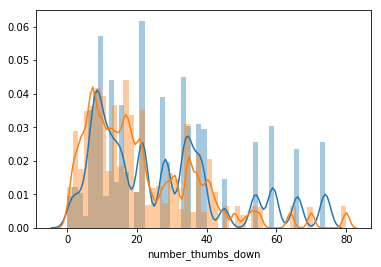

In [95]:
sns.distplot(datapd[datapd['churn']==1]['number_thumbs_down'], kde=True)
sns.distplot(datapd[datapd['churn']==0]['number_thumbs_down'], kde=True)

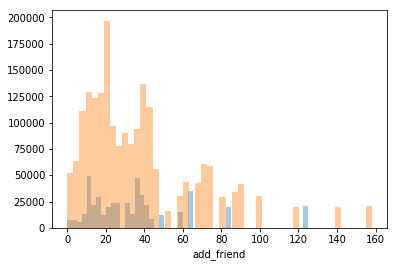

In [82]:
sns.distplot(datapd[datapd['churn']==1]['add_friend'], kde=False)
sns.distplot(datapd[datapd['churn']==0]['add_friend'], kde=False)

In [99]:
print('Best parameters : maxDepth:{}, maxIter:{}'.\
          format(your_model_gb2.getOrDefault('maxDepth'), your_model_gb2.getOrDefault('maxIter')))

Best parameters : maxDepth:5, maxIter:10


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.